In [365]:
import warnings
warnings.filterwarnings(action='ignore')

import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

from os import listdir
from collections import Counter

In [174]:
def load_doc(filename):
    with open(filename) as file:
        text = file.readlines()
        return text

filename = "/content/drive/MyDrive/imagedata/Flickr8k.token.txt"
text = load_doc(filename)
for line in text:
    print(line,end='')

# every image has 5 captions


Streaming output truncated to the last 5000 lines.
3425662680_41c7c50e8d.jpg#4	Jockeys racing horses down a grass track .
3425685827_03683e8e5a.jpg#0	A group of people sitting in a grassy area under a pink and white blossoming tree .
3425685827_03683e8e5a.jpg#1	People are sitting at a park under flowering trees .
3425685827_03683e8e5a.jpg#2	People outside sitting on the grass under cherry blossom trees .
3425685827_03683e8e5a.jpg#3	The students sitting on the grass are eating a lunch from a red backpack .
3425685827_03683e8e5a.jpg#4	Young people sit on the grass near a crooked tree with pink blossoms .
3425756814_13909354d4.jpg#0	A male tennis player holding his tennis racket .
3425756814_13909354d4.jpg#1	A man holding a tennis racket is looking in the distance with his hand over his mouth .
3425756814_13909354d4.jpg#2	A man in a sleeveless blue tennis shirt blows kisses to the fans .
3425756814_13909354d4.jpg#3	A tennis player holds one hand to his mouth and the other holds a racket .

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [175]:
def image_to_captions(text):
    hash_map = {}
    for line in text:
        token = line.split()
        image_id = token[0].split('.')[0] # separating with '.' to extract image id (removing .jpg)
        image_caption = ' '.join(token[1: ])
        
        if(image_id not in hash_map):
            hash_map[image_id] = [image_caption]
        else:
            hash_map[image_id].append(image_caption)
        
    return hash_map
        

map_img_to_captions = image_to_captions(text)
print(*map_img_to_captions['1000268201_693b08cb0e'],sep='\n')


A child in a pink dress is climbing up a set of stairs in an entry way .
A girl going into a wooden building .
A little girl climbing into a wooden playhouse .
A little girl climbing the stairs to her playhouse .
A little girl in a pink dress going into a wooden cabin .


In [366]:
def preprocess(map_img_to_captions):
    preprocessed_captions = []
    for key in map_img_to_captions.keys():
        for idx in range(len(map_img_to_captions[key])):
            tokens = map_img_to_captions[key][idx].split()
            tokens = [token.lower() for token in tokens if len(token)>1 if token.isalpha()]
            map_img_to_captions[key][idx] = ' '.join(tokens)
            
    return map_img_to_captions


preprocessed_map = preprocess(map_img_to_captions)
preprocessed_map['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [367]:
def create_vocabulary(preprocessed_map):
    vocabulary = set()
    for img_captions in preprocessed_map.values(): # list of 5 captions for each image
        for caption in img_captions:
            for token in caption.split():
                vocabulary.add(token)    
    return vocabulary


vocabulary = create_vocabulary(preprocessed_map)
print('Vocabulary size',len(vocabulary))

Vocabulary size 8357


In [368]:
def save_captions(preprocessed_map,filename):
    data = []
    for image_id,image_captions in preprocessed_map.items():
        for caption in image_captions:
            data.append(image_id + ' ' + caption + '\n')
            
    with open(filename,'w') as file:
        for line in data:
            file.write(line)

save_captions(preprocessed_map,'preprocessed_captions.txt')

In [179]:
def img_id_train(filename):
    with open(filename) as file:
        data = file.readlines()
        train_img_name = []
        for img_id in data:
            train_img_name.append(img_id.split('.')[0])
    return train_img_name    

train_img_name = img_id_train('/content/drive/MyDrive/imagedata/Flickr_8k.trainImages.txt')
test_img_name  = img_id_train('/content/drive/MyDrive/imagedata/Flickr_8k.testImages.txt')
print(*train_img_name[:5],sep='\n')
print('\nNumber of images in train data',len(train_img_name))
print('\nNumber of images in train data',len(test_img_name))


2513260012_03d33305cf
2903617548_d3e38d7f88
3338291921_fe7ae0c8f8
488416045_1c6d903fe0
2644326817_8f45080b87

Number of images in train data 6000

Number of images in train data 1000


In [180]:
def load_captions_train(filename):
    doc = load_doc(filename) 
    train_captions = {}    
    
    for line in doc:
        tokens = line.split()
        image_id, image_caption = tokens[0], tokens[1:]

        if(image_id in train_img_name):
            if(image_id not in train_captions):
                train_captions[image_id] = []
            
            modified_caption = 'startseq ' + ' '.join(image_caption) + ' endseq'
            train_captions[image_id].append(modified_caption)
    
    return train_captions


train_captions = load_captions_train('preprocessed_captions.txt')
print(*train_captions['1000268201_693b08cb0e'],sep='\n')


startseq child in pink dress is climbing up set of stairs in an entry way endseq
startseq girl going into wooden building endseq
startseq little girl climbing into wooden playhouse endseq
startseq little girl climbing the stairs to her playhouse endseq
startseq little girl in pink dress going into wooden cabin endseq


In [181]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
def preprocess_image(img_path):
    img = image.load_img('/content/drive/MyDrive/imagedata/Images/'+img_path+".jpg",target_size=(229,229)) 
    
    #print(img)
    #type(img): PIL.Image.Image
    #plt.figure(figsize=(12,6))
    #plt.subplot(121)
    #plt.imshow(img)
    #plt.title('Original Image(Resized)')

    img = image.img_to_array(img) # Converts PIL Image instance to numpy array (299,299,3)
    img = np.expand_dims(img, axis=0) #Add one more dimension: (1, 299, 299, 3) # Inception-V3 requires 4 dimensions
    img = preprocess_input(img) # preprocess image as per Inception-V3 model
#     plt.subplot(122)
#     plt.imshow(img[0])
#     plt.title('Preprocessed image for Inception-V3')    
    
    return img  # shape: (1, 299, 299, 3)

In [182]:
# Load Inception-V3 model
model = InceptionV3(weights='imagenet')

# Create new model, by removing last layer (output layer) from Inception-V3
model_new = Model(inputs=model.input, outputs=model.layers[-2].output) 


In [193]:
# Function to encode given image into a vector of size (2048, )
def encode_image(image):
    image = preprocess_image(image) # preprocess image
    feature_vector = model_new.predict(image) # Get encoding vector for image
    feature_vector = feature_vector.reshape(feature_vector.shape[1], ) # reshape from (1, 2048) to (2048, )
    return feature_vector


In [194]:
# To encode all train images
# To encode all train images
start_train = time()
encoding_train = {}
for idx,img in enumerate(train_img_name):
    if( (idx+1)%500 == 0):
        print('Train images encoded ',idx+1)
    encoding_train[img] = encode_image(img)
print("** Time taken for encoding train images {} seconds **".format(time()-start_train))


Train images encoded  500
Train images encoded  1000
Train images encoded  1500
Train images encoded  2000
Train images encoded  2500
Train images encoded  3000
Train images encoded  3500
Train images encoded  4000
Train images encoded  4500
Train images encoded  5000
Train images encoded  5500
Train images encoded  6000
** Time taken for encoding train images 2124.5911118984222 seconds **


In [195]:
# To encode all test images
start_test = time()
encoding_test = {}
for idx,img in enumerate(test_img_name):
    if( (idx+1)%200 == 0):
        print('Test images encoded ',idx+1)
    encoding_test[img] = encode_image(img)
print("** Time taken for encoding test images {} seconds **".format(time()-start_test))


Test images encoded  200
Test images encoded  400
Test images encoded  600
Test images encoded  800
Test images encoded  1000
** Time taken for encoding test images 505.6633212566376 seconds **


In [197]:
 # Save the bottleneck train features to disk
from pickle import dump, load
with open("encoded_train_images.pkl", "wb") as encoded_pickle:
     dump(encoding_train, encoded_pickle)
    
# # Save the bottleneck test features to disk
with open("encoded_test_images.pkl", "wb") as encoded_pickle:
     dump(encoding_test, encoded_pickle)

In [198]:
train_features = load(open("encoded_train_images.pkl", "rb"))

# Create a list of all the training captions
all_train_captions = []
for captions in train_captions.values():
    for caption in captions:
        all_train_captions.append(caption)
    
print(len(all_train_captions))
print(*all_train_captions[:10],sep='\n')

30000
startseq child in pink dress is climbing up set of stairs in an entry way endseq
startseq girl going into wooden building endseq
startseq little girl climbing into wooden playhouse endseq
startseq little girl climbing the stairs to her playhouse endseq
startseq little girl in pink dress going into wooden cabin endseq
startseq black dog and spotted dog are fighting endseq
startseq black dog and dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq


In [200]:
from collections import Counter
corpus = []
for caption in all_train_captions:
    for token in caption.split():
        corpus.append(token)
        
hash_map = Counter(corpus)
vocab = []
for token,count in hash_map.items():
    if(count>=10):
        vocab.append(token)
        
print('Number of original tokens',len(hash_map))
print('Number of tokens after threshold',len(vocab))

Number of original tokens 7265
Number of tokens after threshold 1643


In [204]:
word_to_index = {}
index_to_word = {}
    
for idx,token in enumerate(vocab):
    word_to_index[token] = idx+1
    index_to_word[idx+1] = token

vocab_size = len(index_to_word) + 1 # one for appended 0's

print(len(index_to_word))

1643


In [205]:
def max_len_caption(all_train_captions):   
    max_len = 0
    for caption in all_train_captions:
        max_len = max(max_len,len(caption.split()))
    print('Maximum length of caption= ',max_len)
    return max_len

max_length_caption = max_len_caption(all_train_captions)

Maximum length of caption=  33


In [86]:
def data_generator(descriptions, photos, wordtoidx, \
                   max_length, num_photos_per_batch):
  # x1 - Training data for photos
  # x2 - The caption that goes with each photo
  # y - The predicted rest of the caption
  x1, x2, y = [], [], []
  n=0
  while True:
    for key, desc_list in descriptions.items():
      n+=1
      photo = photos[key+'.jpg']
      # Each photo has 5 descriptions
      for desc in desc_list:
        # Convert each word into a list of sequences.
        seq = [wordtoidx[word] for word in desc.split(' ') \
               if word in wordtoidx]
        # Generate a training case for every possible sequence and outcome
        for i in range(1, len(seq)):
          in_seq, out_seq = seq[:i], seq[i]
          in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
          out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
          x1.append(photo)
          x2.append(in_seq)
          y.append(out_seq)
      if n==num_photos_per_batch:
        yield ([np.array(x1), np.array(x2)], np.array(y))
        x1, x2, y = [], [], []
        n=0

In [91]:
glove_dir = os.path.join(root_captioning,'glove.6B')
embeddings_index = {} 
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print(f'Found {len(embeddings_index)} word vectors.')

400000it [00:35, 11372.23it/s]

Found 400000 word vectors.


In [92]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoidx.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [93]:
embedding_matrix.shape

(1652, 200)

In [94]:
inputs1 = Input(shape=(OUTPUT_DIM,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
caption_model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [95]:
embedding_dim

200

In [96]:
caption_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 50176)]      0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 34, 200)      330400      input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 50176)        0           input_2[0][0]                    
_______________________________________________________________________________________

In [97]:
caption_model.layers[2].set_weights([embedding_matrix])
caption_model.layers[2].trainable = False
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

In [186]:
count=0

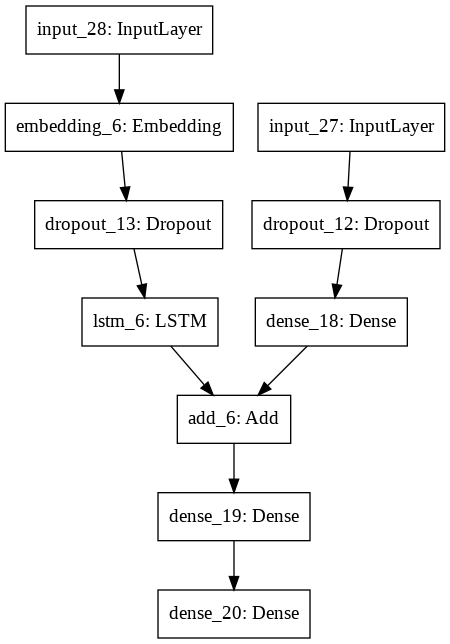

In [283]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [284]:
print(model.layers[2])

model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [285]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [286]:
epochs = 10
number_pics_per_bath = 3
steps = len(train_captions)//number_pics_per_bath

In [ ]:
for i in range(epochs):
    generator = data_generator(train_captions, train_features, word_to_index, max_length_caption, number_pics_per_bath)     
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('/content/drive/MyDrive/imagedata/model/model_' + str(i) + '.h5')

1834/2000 [==========================>...] - ETA: 1:03 - loss: 2.8074

In [361]:
#model.load_weights('/content/drive/MyDrive/imagedata/model/model_3.h5')
from keras import models  

filename = '/content/drive/MyDrive/imagedata/model/model_8.h5'
model = models.load_model(filename)
with open("encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [word_to_index[w] for w in in_text.split() if w in word_to_index]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word=(list(word_to_index.keys())[list(word_to_index.values()).index(yhat)])
        #word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

544576742_283b65fa0d
[[0.02632655 0.02273057 0.07881746 ... 1.3128533  0.3275027  0.2408697 ]]


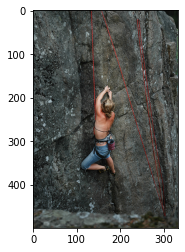

Greedy: man is standing on top of mountain


In [364]:
z=80
images='/content/drive/MyDrive/imagedata/Images/'
pic = list(encoding_test.keys())[z]
print(pic)
image = encoding_test[pic].reshape((1,2048))
print(image)
x=plt.imread(images+pic+".jpg")
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))